# Explore here

In [120]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from urllib.parse import urlparse
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

url = '/workspaces/nlp-PereHDZ/spam.csv'

df = pd.read_csv(url, sep=',')

df.to_csv('spam.csv', index=False)

df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [121]:
df.shape

(2999, 2)

In [122]:
#Check for empty spaces
df.isna().sum()

url        0
is_spam    0
dtype: int64

In [123]:
#Check for unique entries
df.nunique()

url        2369
is_spam       2
dtype: int64

In [124]:
#The difference between entries and unique values means that there are repeated urls. We shall now delete them
df = df.drop_duplicates(subset=['url']).reset_index(drop=True)

df.shape

(2369, 2)

In [125]:
#Process the ULRS
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Custom stopwords specific to URLs
custom_stopwords = set(["www", "http", "https", "com", "org", "net", "html", "php"])
all_stopwords = stop_words.union(custom_stopwords)

# Function to process URLs
def process_url(url):
    # Parse URL and extract components
    parsed_url = urlparse(url)
    
    # Extract meaningful parts (domain, path, query params)
    url_parts = re.split(r'[/\-._?&=]', parsed_url.netloc + parsed_url.path + parsed_url.query)
    
    # Remove empty strings, stopwords, and lemmatize
    processed_words = [
        lemmatizer.lemmatize(word) for word in url_parts
        if word and word.lower() not in all_stopwords
    ]
    
    return ' '.join(processed_words)

df['processed_url'] = df['url'].apply(process_url)

df = df[['processed_url', 'is_spam']]

df.head()

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,processed_url,is_spam
0,briefingday us8 list manage unsubscribe,True
1,hvper,True
2,briefingday v4n3i4f3,True
3,briefingday n 20200618,False
4,briefingday fan,True


In [126]:
#Eliminate any url that may have become empty after processing it
df = df[df.processed_url != '']

#Check if any url has become duplicate after processing them
df.processed_url.duplicated().sum()

np.int64(21)

In [127]:
#Delete the new duplicates
df.drop_duplicates(subset='processed_url', inplace=True)

df.shape

(2348, 2)

In [128]:
#Check the prevalence of True vs False. A huge disparity might unbalance our predictions
df.is_spam.value_counts(normalize=True)

#There is a huge disparity (9 to 1) in our dataset, and we will have to make up for it

is_spam
False    0.898637
True     0.101363
Name: proportion, dtype: float64

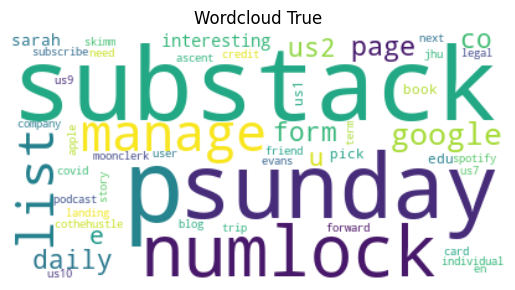

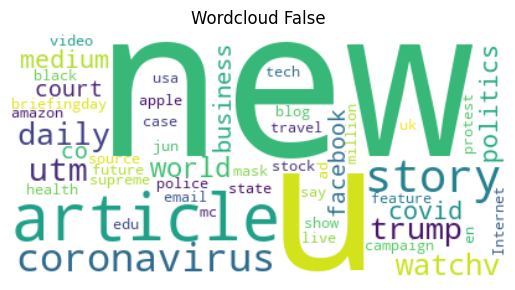

In [129]:
#Show the most common 'words' in our URLs depending on wheter they are spam or not
true_false = df['is_spam'].unique()

for value in true_false:
    text = ''.join(df[df['is_spam'] == value]['processed_url'].tolist())
    wordCloud = WordCloud(background_color = 'white', max_words = 50, contour_color = 'steelblue', collocations = False)
    wordCloud.generate(text)

    plt.imshow(wordCloud, interpolation='bilinear')
    plt.title(f'Wordcloud {value}')
    plt.axis('off')
    plt.show()


In [130]:
#Data split
X_train, X_test, y_train, y_test = train_test_split(df.processed_url, df.is_spam, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

#Correct class imbalance
clf = LogisticRegression(class_weight='balanced', max_iter=1000).fit(X_train_vec, y_train)
y_pred = clf.predict(X_test_vec)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.95      0.96       422
        True       0.63      0.75      0.69        48

    accuracy                           0.93       470
   macro avg       0.80      0.85      0.82       470
weighted avg       0.94      0.93      0.93       470



In [131]:
y_pred_train = clf.predict(X_train_vec)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

       False       1.00      0.98      0.99      1688
        True       0.87      0.99      0.93       190

    accuracy                           0.98      1878
   macro avg       0.94      0.99      0.96      1878
weighted avg       0.99      0.98      0.98      1878



As we can see, our model is quite accurate in its training set, particulary at detecting non-spam urls (with an accuracy of 100%). However, in the test set, the results aren't as good. While the model is still very accurate at predicting non-spam urls, it fails to predict spam ones (with only a 63% accuracy). This indicates overfitting on our model, probably caused due to the class imbalance that we tried to mitigate. In order to fix this issue, it might be advisable to add more entries to our dataset (specially spam ones), or to find other ways to compensate the class imbalance.